# Understanding Simple Recurrent Neural Networks (RNN) in Keras

## Import Libraries

In [1]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## What is a RNN

A recurrent neural network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences. Ordinary feedforward neural networks are only meant for data points that are independent of each other. However, if we have data in a sequence such that one data point depends upon the previous data point, we need to modify the neural network to incorporate the dependencies between these data points. RNNs have the concept of “memory” that helps them store the states or information of previous inputs to generate the next output of the sequence.

## Running the RNN on Sunspots Dataset

 Let’s run a complete RNN on a simple time series dataset. We’ll need to follow these steps:

- Read the dataset from a given URL
- Split the data into training and test sets
- Prepare the input to the required Keras format
- Create an RNN model and train it
- Make the predictions on training and test sets and print the root mean square error on both sets
- View the result

**Step 1, 2: Reading Data and Splitting Into Train and Test**

The following function reads the train and test data from a given URL and splits it into a given percentage of train and test data. It returns single-dimensional arrays for train and test data after scaling the data between 0 and 1 using MinMaxScaler from scikit-learn.

In [2]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df     = read_csv(url, usecols=[1], engine='python')
    data   = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data   = scaler.fit_transform(data).flatten()
    n      = len(data)
    # Point for splitting data into train and test
    split      = int(n*split_percent)
    train_data = data[range(split)]
    test_data  = data[split:]
    return train_data, test_data, data

**Step 3: Reshaping Data for Keras**

The next step is to prepare the data for Keras model training. The input array should be shaped as: total_samples x time_steps x features.

There are many ways of preparing time series data for training. We’ll create input rows with non-overlapping time steps. An example for time steps = 2 is shown in the figure below. Here, time steps denotes the number of previous time steps to use for predicting the next value of the time series data.

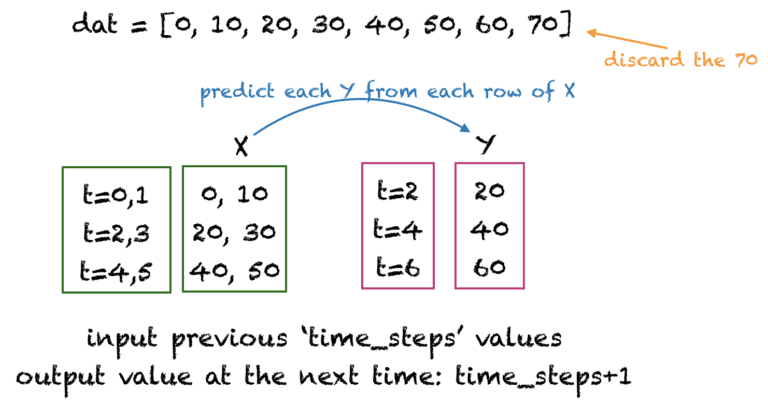

*(source: "Understanding Simple Recurrent Neural Networks in Keras" by Mehreen Saeed, Machine Learning Mastery)* 

The following function `get_XY()` takes a one-dimensional array as input and converts it to the required input X and target Y arrays. We’ll use 12 time_steps for the sunspots dataset as the sunspots generally have a cycle of 12 months. You can experiment with other values of time_steps.

In [3]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

**Step 4: Create RNN Model and Train**

The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time steps are discussed below.

In [4]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

**Step 5: Compute and Print the Root Mean Square Error**

The function print_error() computes the mean square error between the actual and predicted values.

In [5]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

**Step 6: View the Result**

The following function plots the actual target values and the predicted values. The red line separates the training and test data points.

In [6]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

Epoch 1/20
187/187 - 2s - loss: 0.0672 - 2s/epoch - 9ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0162 - 447ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0130 - 411ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0114 - 422ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0100 - 432ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0091 - 436ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0083 - 413ms/epoch - 2ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0076 - 412ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0070 - 426ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0066 - 420ms/epoch - 2ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0061 - 418ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0058 - 413ms/epoch - 2ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0055 - 424ms/epoch - 2ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0053 - 432ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0049 - 456ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

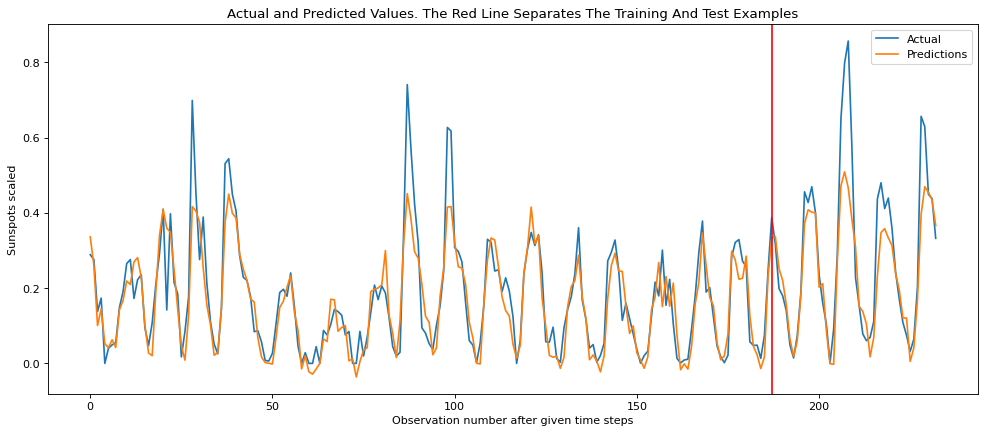

In [7]:
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps   = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

## Reference and Credits

-  Mehreen Saeed **[Understanding Simple Recurrent Neural Networks in Keras](https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/)**, Machine Learning Mastery
---
-  Mehreen Saeed **[An Introduction to Recurrent Neural Networks and the Math That Powers Them](https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/)**, Machine Learning Mastery